# University of Idaho DataScience 2020 Competition

## Collin Heist

## Necessary Package Imports

In [32]:
import numpy as np              # Numpy
import matplotlib.pyplot as plt # Plotting
import seaborn as sns           # Better plotting
import pandas as pd             # Nice 2D viewing
import keras                    # Neural Network Stuff
from tqdm.notebook import tqdm  # Progress Bars on sorting functionality

## Load the train and test data

In [2]:
test_set = np.load('/Volumes/Seagate Backup Plus Drive/Miscellaneous/DataScience2020-Data/test_set.npy')
train_data = np.load('/Volumes/Seagate Backup Plus Drive/Miscellaneous/DataScience2020-Data/train_data.npy').reshape((-1, 64, 64, 1))
train_labels = np.load('/Volumes/Seagate Backup Plus Drive/Miscellaneous/DataScience2020-Data/train_labels.npy')
train_labels = keras.utils.to_categorical(train_labels)

small_test_data = test_set[:len(test_set)//10]
small_train_data = train_data[:len(train_data)//10]
small_train_labels = train_labels[:len(train_labels)//10]

## Function to map the index of the categorical labels to their string-equivalent (for printing)

In [3]:
def expression_map(index):
    return ['x',       'x^2',     'x^3',     'x^4',
            '2x',      '3x^2',    '4x^3',    'x^2 / 2',
            'x^3 / 3', 'x^4 / 4', 'x^5 / 5', '+C',
            't^2 / 2', 't^3 / 3', 't^4 / 4', 't^5 / 5'][index]

expression_map = np.vectorize(expression_map)

## Create a dictionary that has the numerical scores for all gradeable expressions

_The keys of the dictionary are the parsed expressions, with an empty string `''` as the third index if no `'+C'` is given, and the values are the corresponding grades._

In [4]:
expr_10pt = [str(['x', 'x^2 / 2', '+C']),   str(['x^2', 'x^3 / 3', '+C']), str(['x^3', 'x^4 / 4', '+C']),
             str(['x^4', 'x^5 / 5', '+C']), str(['2x', 'x^2', '+C']),      str(['3x^2', 'x^3', '+C']),
             str(['4x^3', 'x^4', '+C'])]
expr_9pt = [str(['x', 'x^2 / 2', '']),   str(['x^2', 'x^3 / 3', '']), str(['x^3', 'x^4 / 4', '']),
            str(['x^4', 'x^5 / 5', '']), str(['2x', 'x^2', '']),      str(['3x^2', 'x^3', '']),
            str(['4x^3', 'x^4', ''])]
expr_5pt = [str(['x', 't^2 / 2', '+C']),   str(['x^2', 't^3 / 3', '+C']),
            str(['x^3', 't^4 / 4', '+C']), str(['x^4', 't^5 / 5', '+C'])]
expr_2pt = [str(['x^2', '2x', '+C']), str(['x^3', '3x^2', '+C']), str(['x^4', '4x^3', '+C'])]
expr_1pt = [str(['x^2', '2x', '']), str(['x^3', '3x^2', '']), str(['x^4', '4x^3', ''])]

grading_dict = dict.fromkeys(expr_10pt, 10)
grading_dict.update(dict.fromkeys(expr_9pt, 9))
grading_dict.update(dict.fromkeys(expr_5pt, 5))
grading_dict.update(dict.fromkeys(expr_2pt, 2))
grading_dict.update(dict.fromkeys(expr_1pt, 1))

## Function to get the expression from a given image - returned as list of relevant values

_Example: `['x^2', 'x^3 / 3', '+C']` is returned for $\int x^2 = \frac{1}{3}x^3+C$._

In [21]:
def get_full_expression(image, model, plus_C_threshold=0.80):
    # val_1 = image[:, 000:064] # Integral - ignore
    val_2 = image[:, 64:128].reshape(1, 64, 64, 1)
    # val_3 = image[:, 128:196] # dx - ignore
    # val_4 = image[:, 196:256] # = - ignore
    val_5 = image[:, 256:320].reshape(1, 64, 64, 1)
    val_6 = image[:, 320:384].reshape(1, 64, 64, 1)
    
    is_plus_C = model.predict(val_6)[0][11] > plus_C_threshold # Must be '+C' if prediction is past the given threshold
    
    first_two = expression_map([np.argmax(model.predict(val_2), axis=1), np.argmax(model.predict(val_5), axis=1)])
    
    return np.append(first_two, ['+C' if is_plus_C else ''])

## Function to return a given expression's corresponding score

_Example: `['x^2', 'x^3 / 3', '+C']` returns 9._

In [22]:
def get_expression_grade(expression):
    try:
        return grading_dict[str(list(expression))]
    except KeyError:
        return 0

## Function to equally subdivide two corresponding  datasets `X` and `Y` for some percentage of test and train data

_Return is a dictionary with keys `'X-Train'`, `'Y-Train'`, `'X-Test'`, and `'Y-Test'`

In [7]:
def subdivide_data(x, y, test_percentage=0.025):
    assert len(x) == len(y), "Lengths of x and y must be equal."
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    
    return {"X-Train": x[indices][:int(len(x) * (1.0 - test_percentage))],
            "Y-Train": y[indices][:int(len(x) * (1.0 - test_percentage))],
            "X-Test": x[indices][-int(len(x) * test_percentage):],
            "Y-Test": y[indices][-int(len(x) * test_percentage):]}

['2x' 'x^2' ''] 9
['x^4' '4x^3' ''] 1
['x' 'x^4 / 4' '+C'] 0
['x' 'x^4 / 4' '+C'] 0
['x^3' 'x^2 / 2' '+C'] 0
['x^4' 't^4 / 4' '+C'] 0
['x^2' '2x' ''] 1
['x^4' 'x^5 / 5' '+C'] 10
['x^2' 'x^3 / 3' '+C'] 10
['x^4' '4x^3' ''] 1
['2x' 'x^4' '+C'] 0
['x^4' 'x^5 / 5' '+C'] 10


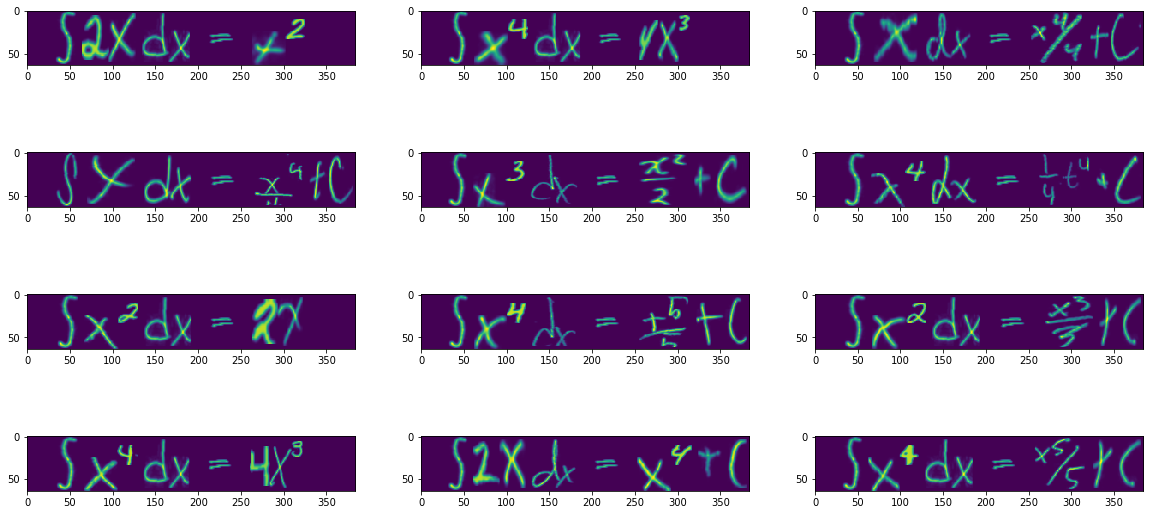

In [17]:
# json_file = open('model2.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model2 = keras.models.model_from_json(loaded_model_json)
# # load weights into new model
# model2.load_weights("model2.h5")

plt.figure(figsize=(20, 10))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.imshow(test_set[i]);
    print (get_full_expression(test_set[i], model2),
           get_expression_grade(get_full_expression(test_set[i], model2)))

## Separate the data into testing and training data for the model, 3% is used for testing

In [7]:
data_dict = subdivide_data(train_data, train_labels, 0.03)

## Model Definition

In [134]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu', input_shape=(64, 64, 1)))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Define the Data Augmentation object to make input images messier


In [38]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30, fill_mode='constant', cval=0.0, width_shift_range=0.25,
    height_shift_range=0.25, zoom_range=0.15)

datagen.fit(train_data)

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

## `DenseNet169`

In [153]:
model2 = keras.applications.densenet.DenseNet169(include_top=True, weights=None, input_shape=(64, 64, 1), classes=16)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [156]:
model2.fit_generator(datagen.flow(train_data, train_labels), epochs=5); # 15
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model2_json = model2.to_json()
with open('model_densenet_169.json', "w") as json_file:
    json_file.write(model2_json)
    
model2.save_weights("model_densenet_169.h5")

Epoch 1/5
250/250 [==============================] - 634s 3s/step - loss: 0.1979 - accuracy: 0.9334
Epoch 2/5
250/250 [==============================] - 653s 3s/step - loss: 0.1684 - accuracy: 0.9448
Epoch 3/5
250/250 [==============================] - 946s 4s/step - loss: 0.1568 - accuracy: 0.9457
Epoch 4/5
250/250 [==============================] - 579s 2s/step - loss: 0.1417 - accuracy: 0.9479
Epoch 5/5
250/250 [==============================] - 564s 2s/step - loss: 0.1120 - accuracy: 0.9613


## `DenseNet201`

### Create the Model

In [39]:
model_densenet_201 = keras.applications.densenet.DenseNet201(include_top=True, weights=None, input_shape=(64, 64, 1), classes=16)
model_densenet_201.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [46]:
model_densenet_201.fit_generator(datagen.flow(train_data, train_labels), epochs=5); # 10 epochs ~ 94.09%

Epoch 1/5
250/250 [==============================] - 1258s 5s/step - loss: 0.1625 - accuracy: 0.9440
Epoch 2/5
250/250 [==============================] - 1289s 5s/step - loss: 0.1685 - accuracy: 0.9438
Epoch 3/5
250/250 [==============================] - 1207s 5s/step - loss: 0.1709 - accuracy: 0.9434
Epoch 4/5
250/250 [==============================] - 1240s 5s/step - loss: 0.1498 - accuracy: 0.9477
Epoch 5/5
250/250 [==============================] - 1062s 4s/step - loss: 0.1496 - accuracy: 0.9465


### Save the Model to a File

In [47]:
model_densenet_201_json = model_densenet_201.to_json()
with open('model_densenet_201-15.json', 'w') as json_file:
    json_file.write(model_densenet_201_json)
model_densenet_201.save_weights("model_densenet_201-15.h5")

### Make and save the Predictions

In [48]:
predictions_201 = []
for entry in tqdm(test_set, ncols='100%', unit=' predictions', desc='Making Predictions'):
    predictions_201.append(get_expression_grade(get_full_expression(entry, model_densenet_201)))
np.save("densenet_201_predictions15.npy", predictions_201)